# Predict MQ scores

Given term-specific datasets, we build a loop that predicts MQ scores within each dataset (or within a moving window of several terms).

Our data will be aggregated by case & justice — so, everything Justice Y said during case X.

We'll hold out justices during prediction, so we don't use any of Felix Frankfurter's own remarks in the training set to predict Frankfurter's MQ score.

In [193]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import zscore

## An example on a specific term

Let's see how this works in one term, before we run the process on the whole sequence. This will allow us to tune some parameters, and also allow me to comment and illustrate intermediate stages of analysis.

Let's start with 1990, for no good reason. Read in the data and look at the first five rows.

In [210]:
yearly = []

for term in range(1990, 1995):
    infile = '/Volumes/TARDIS/oralarg/termgrouped/term' + str(term) + '.tsv'
    data = pd.read_csv(infile, sep = '\t')
    yearly.append(data)

data = pd.concat(yearly, ignore_index = True)

data = data.loc[data.wordct > 100, : ]
# I'm dropping rows with less than a hundred words,
# because that's not much data.

data.reset_index(inplace = True)
data = data.assign(fold = data.index % 10)

In [211]:
print("The #rows and #columns of the data:", data.shape)
data.tail()

The #rows and #columns of the data: (2943, 7)


,index,justice,mq,speakercase,text,wordct,fold
2938,3368,DHSouter,-0.317,1994-092-DHSouter,--There certainly wasn't a consensus to draw a...,1130,8
2939,3369,JPStevens,-3.012,1994-092-JPStevens,Don't you think the answer to Justice Scalia's...,568,9
2940,3371,SDOConnor,0.829,1994-092-SDOConnor,"Well, why is district shape any more objective...",257,0
2941,3372,SGBreyer,-0.306,1994-092-SGBreyer,"So then in your... sorry. So then, in your vie...",627,1
2942,3373,WHRehnquist,1.871,1994-092-WHRehnquist,"We'll hear argument next in Number 94-631, Mil...",293,2


Now we're going to transform the "text" column into a matrix where the rows line up with the row count of the original data, but the columns are words. Each cell will have the count of that word in that row.

To do this we start by creating a "vectorizer," an object that will do the counting.

In [212]:
vectorizer = CountVectorizer(max_features = 1200)

Then we ask the vectorizer to transform the text column, creating a term-document matrix.

In [213]:
termdoc = vectorizer.fit_transform(data.text)

In [214]:
termdoc.shape

(2943, 1200)

The term-doc matrix has 713 rows--just like the original data--and 3000 columns. What are those columns?

To find out, we have to "unpack" the sparse (compressed) term-doc matrix into something with labels.

In [215]:
vocab = vectorizer.get_feature_names()
td = pd.DataFrame(termdoc.toarray(), columns = vocab)
td.head()

,000,10,100,11,12,1983,20,30,50,60,...,written,wrong,yeah,year,years,yes,yet,york,you,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,3
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,7,0


In [216]:
td = td.div(td.sum(axis=1), axis=0)
td.head()

,000,10,100,11,12,1983,20,30,50,60,...,written,wrong,yeah,year,years,yes,yet,york,you,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.022222,0.007407
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.040698,0.005814
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.002304,0.0,0.0,0.032258,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.037879,0.007576
4,0.0,0.0,0.0,0.0,0.0,0.0,0.004292,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.004292,0.000000,0.0,0.0,0.030043,0.000000


You can see that most of the columns are fairly rare words, but "you," for instance, is rather common.

### Let's make predictions

The key here is to divide the dataset up by "justice," so that we aren't simply recognizing a justice's own style, but predicting their ideology using linguistic patterns from their *colleagues.* Otherwise, our accuracy could be a measure of "stylistic idiosyncrasy" rather than "linguistic polarization."

To illustrate how much difference this makes, let's start by **doing things wrong!** Instead of dividing the data by justice, we'll divide it by ten random "folds" that are basically the last digit of the row number.

In [217]:
predictions = [float('nan') for x in range(data.shape[0])]

for fold in set(data.fold):
    print(fold)
    
    justice_row_nums = data.index[data.fold == fold]
    
    # Note that although I call this justice_row_nums
    # these are not really rows for a single justice yet;
    # they're just rows associated with a random tenth of
    # the dataset.
    
    justice_rows = td.loc[justice_row_nums, : ]
    
    other_row_nums = np.ones(td.shape[0], dtype = bool)
    # creates a list that's all True
    other_row_nums[justice_row_nums] = False
    # now we've masked the rows for this justice
    other_rows = td.loc[other_row_nums, : ]
    
    ridge = Ridge(alpha = 10, normalize = False)
    scaler = StandardScaler(with_mean = True)
    
    X = scaler.fit_transform(other_rows)
    y = data.loc[other_row_nums, 'mq']
    
    ridge.fit(X, y)
    
    newX = scaler.transform(justice_rows)
    yhat = ridge.predict(newX)
    
    for rownum, prediction in zip(justice_row_nums, yhat):
        if not pd.isnull(predictions[rownum]):
            print('error')
        predictions[rownum] = prediction
    
predictions = np.array(predictions)
pearsonr(predictions, data.mq)    

0
1
2
3
4
5
6
7
8
9


(0.64882558489683573, 0.0)

Wow, a Pearson's correlation of .55 is pretty strong. Let's visualize that: we'll plot the actual MQ score horizontally and the predicted score vertically.

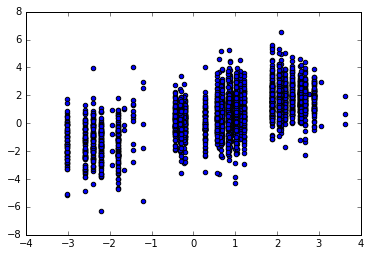

In [218]:
plt.scatter(data.mq, predictions)

If you want to get the actual and predicted means for justices, that's easy too:

In [219]:
for judge in set(data.justice):
    rownums = data.index[data.justice == judge]
    predictedmean = np.mean(predictions[rownums])
    actualmean = np.mean(data.loc[rownums, 'mq'])
    print(judge, " \tprediction:", predictedmean, "\tactual:", actualmean)

WHRehnquist  	prediction: 1.87341856539 	actual: 2.07030853392
BRWhite  	prediction: 0.597069626072 	actual: 0.597775193798
RBGinsburg  	prediction: 0.148375371085 	actual: -0.315770700637
HABlackmun  	prediction: -0.148739642332 	actual: -1.53818518519
SDOConnor  	prediction: 0.893777103922 	actual: 0.898397759104
AScalia  	prediction: 1.80088829195 	actual: 2.55097180043
DHSouter  	prediction: 0.225410120064 	actual: 0.194697329377
AMKennedy  	prediction: 0.786806798982 	actual: 0.979639473684
SGBreyer  	prediction: 0.106791820368 	actual: -0.306
CThomas  	prediction: 1.24586928921 	actual: 3.29166666667
JPStevens  	prediction: -1.39999734506 	actual: -2.36083486239


#### the problem

We're not really predicting ideology. We're just recognizing justices' individual styles.

Let's do it right, by holding out all the rows for one justice at a time.

In [220]:
predictions = [float('nan') for x in range(data.shape[0])]

for judge in set(data.justice):
    print(judge)
    
    # Now we're really going to identify rows associated
    # with a specific justice.
    
    justice_row_nums = data.index[data.justice == judge]
    justice_rows = td.loc[justice_row_nums, : ]
    
    other_row_nums = np.ones(td.shape[0], dtype = bool)
    # creates a list that's all True
    other_row_nums[justice_row_nums] = False
    # now we've masked the rows for this justice
    other_rows = td.loc[other_row_nums, : ]
    
    ridge = Ridge(alpha = 50000, normalize = False)
    scaler = StandardScaler(with_mean = True)
    
    X = scaler.fit_transform(other_rows)
    y = data.loc[other_row_nums, 'mq']
    
    ridge.fit(X, y)
    
    newX = scaler.transform(justice_rows)
    yhat = ridge.predict(newX)
    
    for rownum, prediction in zip(justice_row_nums, yhat):
        if not pd.isnull(predictions[rownum]):
            print('error')
        predictions[rownum] = prediction

predictions = np.array(predictions)
pearsonr(predictions, data.mq)   
    

WHRehnquist
BRWhite
RBGinsburg
HABlackmun
SDOConnor
AScalia
DHSouter
AMKennedy
SGBreyer
CThomas
JPStevens


(-0.87190148132397627, 0.0)

Wait, what? Now we've got a **negative** correlation! How is that possible??

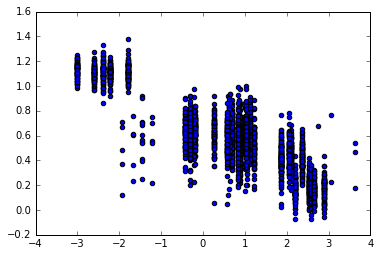

In [221]:
plt.scatter(data.mq, predictions)

Predicted MQ score is now strongly *negatively* correlated with real MQ score.

The reason is that removing one justice from the group biases the group mean *away* from the ideological position of the justice we removed. So when you remove Scalia, the model is going to learn that the mean MQ score is pretty liberal! To do this right, we need to make sure that the mean MQ score in the training set is always zero.

We'll do that by converting MQ scores into z-scores: we'll subtract the mean, and divide by standard deviation, before running a model.

#### Finally doing it 100% right

In [222]:
data = data.assign(z = zscore(data.mq))

In [246]:
predictions = [float('nan') for x in range(data.shape[0])]

for judge in set(data.justice):
    print(judge)
    
    # Now we're really going to identify rows associated
    # with a specific justice.
    
    justice_row_nums = data.index[data.justice == judge]
    justice_rows = td.loc[justice_row_nums, : ]
    
    other_row_nums = np.ones(td.shape[0], dtype = bool)
    # creates a list that's all True
    other_row_nums[justice_row_nums] = False
    # now we've masked the rows for this justice
    other_rows = td.loc[other_row_nums, : ]
    
    ridge = Ridge(alpha = 800, normalize = False)
    scaler = StandardScaler(with_mean = False)
    
    X = scaler.fit_transform(other_rows)
    y = zscore(data.loc[other_row_nums, 'mq'])
    
    ridge.fit(X, y)
    
    newX = scaler.transform(justice_rows)
    yhat = ridge.predict(newX)
    
    for rownum, prediction in zip(justice_row_nums, yhat):
        if not pd.isnull(predictions[rownum]):
            print('error')
        predictions[rownum] = prediction

predictions = np.array(predictions)
pearsonr(predictions, data.z)  

WHRehnquist
BRWhite
RBGinsburg
HABlackmun
SDOConnor
AScalia
DHSouter
AMKennedy
SGBreyer
CThomas
JPStevens


(0.18606377499329227, 2.4717108859199947e-24)

**analysis:** It's a pretty slight effect, as we might expect. Inferring ideology from relatively brief questions is not an easy task.

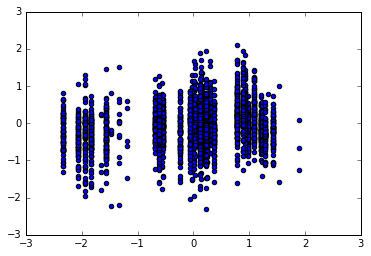

In [249]:
plt.scatter(data.z, predictions)

### Predictions broken out by justice

The scatterplot above has vertical columns, because each justice/term combination is associated with a single realMQ score on the horizontal axis, but we make lots of different predictions for individual cases on the vertical axis. 

Let's aggregate the predictions for each justice to get a clearer picture.

WHRehnquist  	prediction: 0.291407393297 	actual: 2.07030853392
BRWhite  	prediction: -0.102358416359 	actual: 0.597775193798
RBGinsburg  	prediction: -0.077985772971 	actual: -0.315770700637
HABlackmun  	prediction: -0.343791074121 	actual: -1.53818518519
SDOConnor  	prediction: 0.133287315808 	actual: 0.898397759104
AScalia  	prediction: -0.219418594729 	actual: 2.55097180043
DHSouter  	prediction: -0.171486764032 	actual: 0.194697329377
AMKennedy  	prediction: -0.175272553993 	actual: 0.979639473684
SGBreyer  	prediction: -0.103490880187 	actual: -0.306
CThomas  	prediction: -0.27460503163 	actual: 3.29166666667
JPStevens  	prediction: -0.328770843548 	actual: -2.36083486239


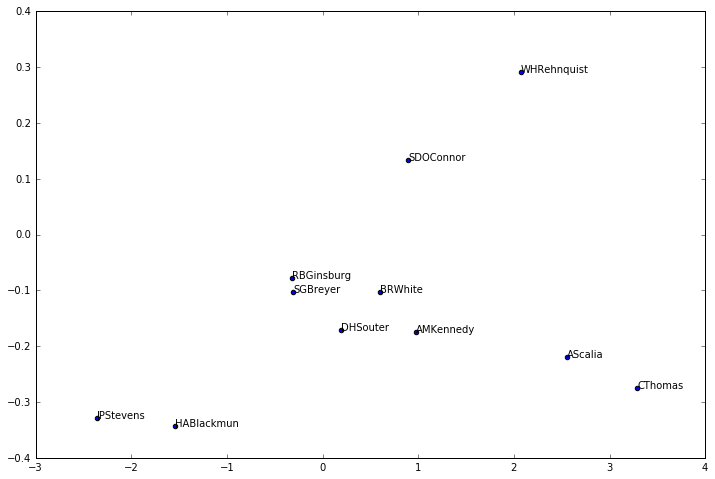

In [248]:
actual_z = []
predicted_z = []
justices = []

for judge in set(data.justice):
    rownums = data.index[data.justice == judge]
    predictedmean = np.mean(predictions[rownums])
    actualmean = np.mean(data.loc[rownums, 'mq'])
    print(judge, " \tprediction:", predictedmean, "\tactual:", actualmean)
    actual_z.append(actualmean)
    predicted_z.append(predictedmean)
    justices.append(judge)

fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(actual_z, predicted_z)

for i, txt in enumerate(justices):
    ax.annotate(txt, (actual_z[i], predicted_z[i]))

### Tuning parameters to find a best setting

In particular, how many features should we use?

When you're not cross-validating well, it can seem effective to include thousands and thousands of features, because you're really just memorizing the personal styles of justices.

But when you rigorously divide the dataset by justice, prediction is harder, and it turns out that we're relying on a rather small set of common words.

In [299]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

features = []
alphas = []
errors = []

for numfeatures in range(100, 1000, 80):
    vectorizer = CountVectorizer(max_features = numfeatures)
    termdoc = vectorizer.fit_transform(data.text)
    td = pd.DataFrame(termdoc.toarray())
    td = td.div(td.sum(axis=1), axis=0)
    
    for alpha in [.001, .1, 1, 5, 10, 50, 100, 400, 1000]:
        
        predictions = [float('nan') for x in range(data.shape[0])]

        for judge in set(data.justice):

            # Now we're really going to identify rows associated
            # with a specific justice.

            justice_row_nums = data.index[data.justice == judge]
            justice_rows = td.loc[justice_row_nums, : ]

            other_row_nums = np.ones(td.shape[0], dtype = bool)
            # creates a list that's all True
            other_row_nums[justice_row_nums] = False
            # now we've masked the rows for this justice
            other_rows = td.loc[other_row_nums, : ]

            ridge = Ridge(alpha = alpha, normalize = False)
            scaler = StandardScaler(with_mean = False)

            X = scaler.fit_transform(other_rows)
            y = zscore(data.loc[other_row_nums, 'mq'])

            ridge.fit(X, y)

            newX = scaler.transform(justice_rows)
            yhat = ridge.predict(newX)

            for rownum, prediction in zip(justice_row_nums, yhat):
                if not pd.isnull(predictions[rownum]):
                    print('error')
                predictions[rownum] = prediction

        predictions = np.array(predictions)
        error = rmse(predictions, data.z)
        cor = pearsonr(predictions, data.z)[0]
        
        features.append(numfeatures)
        alphas.append(alpha)
        if cor <= 0:
            r2 = 0
        else:
            r2 = cor ** 2
        errors.append(r2)
        print(numfeatures, '\t', alpha, '\t', error, '\t', cor)

100 	 0.001 	 1.1190293704 	 0.0350398673119
100 	 0.1 	 1.11902099906 	 0.035041931736
100 	 1 	 1.11894496147 	 0.0350606692353
100 	 5 	 1.11860843516 	 0.0351432970404
100 	 10 	 1.11819099837 	 0.0352451068064
100 	 50 	 1.11497369938 	 0.036003821254
100 	 100 	 1.11122905856 	 0.0368268783337
100 	 400 	 1.09339860953 	 0.0397665998891
100 	 1000 	 1.07085382124 	 0.0407948931208
180 	 0.001 	 1.05158499655 	 0.192719645139
180 	 0.1 	 1.0515775671 	 0.192720836473
180 	 1 	 1.05151013588 	 0.192731578825
180 	 5 	 1.05121279195 	 0.192777440607
180 	 10 	 1.05084637414 	 0.192830600988
180 	 50 	 1.04810310195 	 0.193114542736
180 	 100 	 1.04506285164 	 0.193204772007
180 	 400 	 1.03215720037 	 0.191139728189
180 	 1000 	 1.01839961765 	 0.184390621472
260 	 0.001 	 1.04647023919 	 0.233983075071
260 	 0.1 	 1.04646195591 	 0.233982226379
260 	 1 	 1.04638677799 	 0.233974450066
260 	 5 	 1.04605533822 	 0.233938586798
260 	 10 	 1.04564705561 	 0.233890884005
260 	 50 	 1.04

In [300]:
len([x for x in range(100, 1000, 80)])

12

In [301]:
grid = np.matrix(np.array_split(errors, 12))

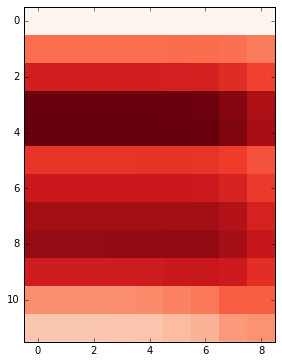

In [302]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(grid, cmap=plt.cm.Reds, interpolation='none')
ax.set_aspect(1)

#### result of tuning

The best setting (for this data) is 420 features and alpha = 0.1.

We're going to pray that this setting is reasonably good for the whole timeline. If it's necessary to tune separately for each segment of the timeline, we enter a world where validation is trickier, because we need to prove that we're not overfitting by tuning.

But in reality, if there's that much volatility in the model, we probably won't have a signal worth discussing anyway.

In [305]:
vectorizer = CountVectorizer(max_features = 420)
termdoc = vectorizer.fit_transform(data.text)
td = pd.DataFrame(termdoc.toarray())
td = td.div(td.sum(axis=1), axis=0)

predictions = [float('nan') for x in range(data.shape[0])]

for judge in set(data.justice):

    # Now we're really going to identify rows associated
    # with a specific justice.

    justice_row_nums = data.index[data.justice == judge]
    justice_rows = td.loc[justice_row_nums, : ]

    other_row_nums = np.ones(td.shape[0], dtype = bool)
    # creates a list that's all True
    other_row_nums[justice_row_nums] = False
    # now we've masked the rows for this justice
    other_rows = td.loc[other_row_nums, : ]

    ridge = Ridge(alpha = 0.1, normalize = False)
    scaler = StandardScaler(with_mean = False)

    X = scaler.fit_transform(other_rows)
    y = zscore(data.loc[other_row_nums, 'mq'])

    ridge.fit(X, y)

    newX = scaler.transform(justice_rows)
    yhat = ridge.predict(newX)

    for rownum, prediction in zip(justice_row_nums, yhat):
        if not pd.isnull(predictions[rownum]):
            print('error')
        predictions[rownum] = prediction

predictions = np.array(predictions)
error = rmse(predictions, data.z)
cor = pearsonr(predictions, data.z)[0]

r2 = cor ** 2
print(cor, r2)

0.273962329654 0.0750553580693


WHRehnquist  	prediction: 0.939030473659 	actual: 2.07030853392
BRWhite  	prediction: -0.0930903931003 	actual: 0.597775193798
RBGinsburg  	prediction: -0.115028663711 	actual: -0.315770700637
HABlackmun  	prediction: -0.120071764006 	actual: -1.53818518519
SDOConnor  	prediction: 0.101715991449 	actual: 0.898397759104
AScalia  	prediction: -0.304506810423 	actual: 2.55097180043
DHSouter  	prediction: -0.15073206673 	actual: 0.194697329377
AMKennedy  	prediction: -0.198934782975 	actual: 0.979639473684
SGBreyer  	prediction: -0.0869531628548 	actual: -0.306
CThomas  	prediction: -0.159412724837 	actual: 3.29166666667
JPStevens  	prediction: -0.423326528703 	actual: -2.36083486239


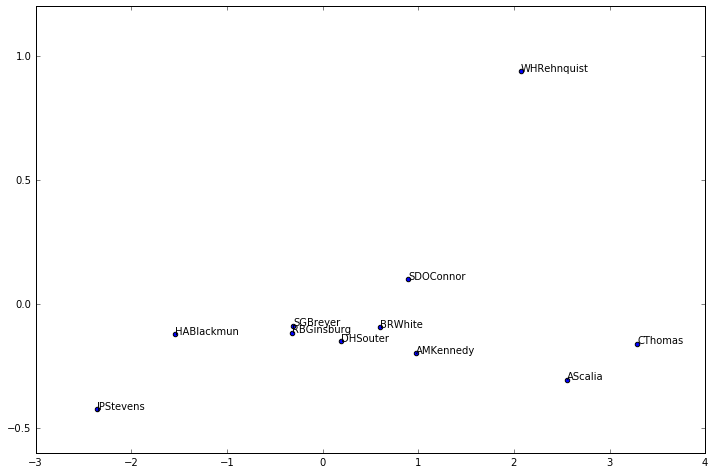

In [306]:
actual_z = []
predicted_z = []
justices = []

for judge in set(data.justice):
    rownums = data.index[data.justice == judge]
    predictedmean = np.mean(predictions[rownums])
    actualmean = np.mean(data.loc[rownums, 'mq'])
    print(judge, " \tprediction:", predictedmean, "\tactual:", actualmean)
    actual_z.append(actualmean)
    predicted_z.append(predictedmean)
    justices.append(judge)

fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(actual_z, predicted_z)

for i, txt in enumerate(justices):
    ax.annotate(txt, (actual_z[i], predicted_z[i]))

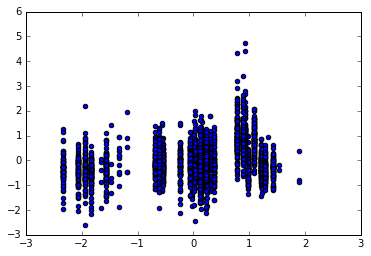

In [307]:
plt.scatter(data.z, predictions)